### 1. Import dependencies

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim

In [3]:
import torchfunc
import flowDataset
from torch.utils.data.sampler import SubsetRandomSampler


In [4]:
torch.__version__
torchfunc.cuda.reset()
torch.cuda.empty_cache()

### 2. Create PyTorch data generators

In [5]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((500,500)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((500,500)),
        transforms.ToTensor(),
        normalize
    ]),
}


In [6]:
dataset = flowDataset.flowDataset(data_transforms['train'])

In [7]:
batch_size = 50
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

In [8]:
dataloaders = {
    'train': train_loader,
    'validation': test_loader
}

### 3. Create the network

In [9]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
device = torch.device("cuda:0")

In [10]:
model = models.resnet50(pretrained=True).to(device)
    
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 1024),
               nn.ReLU(inplace=True),
               nn.Linear(1024, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 7)).to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(),lr=0.0001)

### 4. Train the model

In [12]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects.float() / len(dataloaders[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss.item(), epoch_acc.item()))
    return model

In [13]:
model_trained = train_model(model, criterion, optimizer, num_epochs=50)

Epoch 1/50
----------


C:\Users\reese\miniconda3\envs\final-year-project\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train loss: 79.3405, acc: 19.5926
validation loss: 69.0661, acc: 19.5714
Epoch 2/50
----------
train loss: 66.1029, acc: 22.9259
validation loss: 59.8234, acc: 22.4286
Epoch 3/50
----------
train loss: 58.1883, acc: 26.5926
validation loss: 52.4236, acc: 25.5714
Epoch 4/50
----------
train loss: 52.5189, acc: 28.5926
validation loss: 47.8259, acc: 31.2857
Epoch 5/50
----------
train loss: 48.6201, acc: 32.0000
validation loss: 44.6320, acc: 30.2857
Epoch 6/50
----------
train loss: 45.5813, acc: 31.5185
validation loss: 41.2129, acc: 33.1429
Epoch 7/50
----------
train loss: 43.8131, acc: 31.6296
validation loss: 40.4340, acc: 31.7143
Epoch 8/50
----------
train loss: 42.2581, acc: 32.9630
validation loss: 38.6630, acc: 32.4286
Epoch 9/50
----------
train loss: 39.1600, acc: 33.7407
validation loss: 35.6337, acc: 35.0000
Epoch 10/50
----------
train loss: 37.9093, acc: 34.4074
validation loss: 35.3546, acc: 34.4286
Epoch 11/50
----------
train loss: 36.5262, acc: 34.4815
validation los

### 5. Save and load the model

In [14]:
torch.save(model_trained.state_dict(), 'models/pytorch/weights.h5')

In [15]:
model = models.resnet50(pretrained=False).to(device)
model.fc = nn.Sequential(
               nn.Linear(2048, 1024),
               nn.ReLU(inplace=True),
               nn.Linear(1024, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 7)).to(device)
model.load_state_dict(torch.load('models/pytorch/weights.h5'))

<All keys matched successfully>

### 6. Make predictions on sample test images

In [16]:
validation_img_paths = ["D:/Flow Videos/dataset/frame_485.jpg",
                        "D:/Flow Videos/dataset/frame_536.jpg",
                        "D:/Flow Videos/dataset/frame_450.jpg"]
img_list = [Image.open(img_path) for img_path in validation_img_paths]

In [17]:
validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                for img in img_list])

In [18]:
pred_logits_tensor = model(validation_batch)
pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()

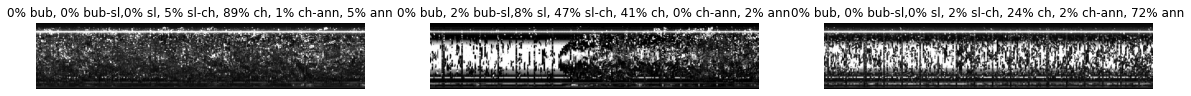

In [19]:
fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
for i, img in enumerate(img_list):
    ax = axs[i]
    ax.axis('off')
    ax.set_title("{:.0f}% bub, {:.0f}% bub-sl,{:.0f}% sl, {:.0f}% sl-ch, {:.0f}% ch, {:.0f}% ch-ann, {:.0f}% ann".format(
    100*pred_probs[i,0], 100*pred_probs[i,1],100*pred_probs[i,2],100*pred_probs[i,3],100*pred_probs[i,4],100*pred_probs[i,5],100*pred_probs[i,6]))
    ax.imshow(img)